In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Feb 13 20:13:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
|  0%   48C    P8              35W / 200W |   5153MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Hyper-Parameters

In [4]:
from easydict import EasyDict
from diffusers import DDPMScheduler

hp = EasyDict()

# Data
hp.dataset = 'ffhq_256'
hp.data_root = '/home/scpark/data'
hp.test_eval = True
hp.image_size = 256
hp.image_channels = 3
hp.n_batch = 8

# Model
hp.custom_width_str = ""
hp.bottleneck_multiple = 0.25
hp.no_bias_above = 64
hp.num_mixtures = 10
hp.width = 512
hp.zdim = 16
hp.dec_blocks = "1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128"
hp.enc_blocks = "256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4"


### Model

In [6]:
from model.main.vdvae_latent import Model as VAE
from model.encoder.vdvae_encoder import Encoder
from model.decoder.vdvae_decoder import Decoder
from model.loss.dmol import Loss

In [8]:
device = 'cuda:0'
vae = VAE(Encoder(hp), Decoder(hp), Loss(hp)).to(device)
print('done')

done


### Load

In [9]:
checkpoint_path = '/data/checkpoint/ffhq256-iter-1700000-model-ema.th'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

model_state_dict = vae.state_dict()
for key in checkpoint.keys():
    if key.startswith('encoder'):
        model_key = 'encoder.' + key
        if model_key in model_state_dict:
            model_state_dict[model_key] = checkpoint[key]
        else:
            print(model_key)
    if key.startswith('decoder'):
        if key.startswith('decoder.out_net'):
            model_key = 'loss.' + key[8:]
        else:
            model_key = 'decoder.' + key
            
        if model_key in model_state_dict:
            model_state_dict[model_key] = checkpoint[key]
        else:
            print(model_key)
            
vae.load_state_dict(model_state_dict)
print('done')

done


In [16]:
vae.eval()
with torch.no_grad():
    samples = vae.sample(5)
    print(samples.shape)

(5, 256, 256, 3)


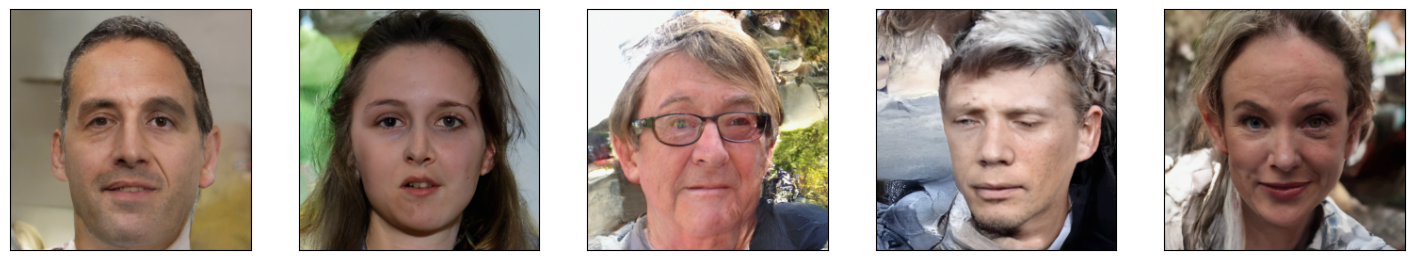

In [17]:
def show_samples(samples):
    import matplotlib.pyplot as plt
    N = len(samples)
    plt.figure(figsize=[18, 4])
    for i in range(len(samples)):
        plt.subplot(1, N, i+1)
        plt.imshow(samples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
show_samples(samples)